In [1]:
import altair as alt
import numpy as np
import pandas as pd
import pandas_profiling
import seaborn as sns
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import wordcloud as wc
import sqlite3
import datetime
# import stats
from sklearn.cluster import KMeans

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 100

%load_ext sql
# %config InlineBackend.figure_formats = ['svg']

# Load data

In [2]:
rdf = pd.read_csv('crime_stats.csv', index_col='Row_Value_ID', parse_dates=['REPORT_DATE'])

In [3]:
rdf.head()

,Police Beat,CRIME_TYPE,CRIME_DESCRIPTION,STAT_VALUE,REPORT_DATE,Sector,Precinct
Row_Value_ID,,,,,,,
1,B1,Homicide,Homicide,0,2008-01-01,B,N
2,B1,Rape,Rape,0,2008-01-01,B,N
3,B1,Robbery,Robbery,5,2008-01-01,B,N
4,B1,Assault,Assault,1,2008-01-01,B,N
5,B1,Larceny-Theft,Larceny-Theft,35,2008-01-01,B,N


# Clean dataset

In [4]:
df = rdf.rename(columns = {
  'REPORT_DATE': 'Date', 
  'STAT_VALUE': 'Cases', 
  'CRIME_TYPE': 'Type',
  'Police Beat': 'Beat',
})
df = df.drop('CRIME_DESCRIPTION', axis=1)
df = df[df.Cases >= 0]
#I dropped the rows where the number of incidents (STAT_VALUE) was negative (probably a mistake?)

In [5]:
df.head()

,Beat,Type,Cases,Date,Sector,Precinct
Row_Value_ID,,,,,,
1,B1,Homicide,0,2008-01-01,B,N
2,B1,Rape,0,2008-01-01,B,N
3,B1,Robbery,5,2008-01-01,B,N
4,B1,Assault,1,2008-01-01,B,N
5,B1,Larceny-Theft,35,2008-01-01,B,N


# Take a look at each column

In [6]:
beats = list(df['Beat'].unique())
beats.sort()
beats

['B1',
 'B2',
 'B3',
 'C1',
 'C2',
 'C3',
 'D1',
 'D2',
 'D3',
 'E1',
 'E2',
 'E3',
 'F1',
 'F2',
 'F3',
 'G1',
 'G2',
 'G3',
 'J1',
 'J2',
 'J3',
 'K1',
 'K2',
 'K3',
 'L1',
 'L2',
 'L3',
 'M1',
 'M2',
 'M3',
 'N1',
 'N2',
 'N3',
 'O1',
 'O2',
 'O3',
 'Q1',
 'Q2',
 'Q3',
 'R1',
 'R2',
 'R3',
 'S1',
 'S2',
 'S3',
 'U1',
 'U2',
 'U3',
 'W1',
 'W2',
 'W3']

Note: The letter refers to the sector. So every sector has 3 beats (1, 2, and 3)

In [7]:
sectors = list(df['Sector'].unique())
sectors.sort()
sectors

['B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'Q',
 'R',
 'S',
 'U',
 'W']

See https://www.seattle.gov/police/information-and-data/tweets-by-beat for a map of these beats and sectors

In [8]:
df['Precinct'].unique()

array(['N', 'W', 'E', 'SE', 'SW'], dtype=object)

In [9]:
df[['Beat', 'Sector', 'Precinct']].nunique()

Beat        51
Sector      17
Precinct     5
dtype: int64

In [10]:
crime_types = list(df['Type'].unique())
crime_types

['Homicide',
 'Rape',
 'Robbery',
 'Assault',
 'Larceny-Theft',
 'Motor Vehicle Theft',
 'Burglary']

In [11]:
dates = list(df['Date'].unique())
dates.sort()
dates

[numpy.datetime64('2008-01-01T00:00:00.000000000'),
 numpy.datetime64('2008-02-01T00:00:00.000000000'),
 numpy.datetime64('2008-03-01T00:00:00.000000000'),
 numpy.datetime64('2008-04-01T00:00:00.000000000'),
 numpy.datetime64('2008-05-01T00:00:00.000000000'),
 numpy.datetime64('2008-06-01T00:00:00.000000000'),
 numpy.datetime64('2008-07-01T00:00:00.000000000'),
 numpy.datetime64('2008-08-01T00:00:00.000000000'),
 numpy.datetime64('2008-09-01T00:00:00.000000000'),
 numpy.datetime64('2008-10-01T00:00:00.000000000'),
 numpy.datetime64('2008-11-01T00:00:00.000000000'),
 numpy.datetime64('2008-12-01T00:00:00.000000000'),
 numpy.datetime64('2009-01-01T00:00:00.000000000'),
 numpy.datetime64('2009-02-01T00:00:00.000000000'),
 numpy.datetime64('2009-03-01T00:00:00.000000000'),
 numpy.datetime64('2009-04-01T00:00:00.000000000'),
 numpy.datetime64('2009-05-01T00:00:00.000000000'),
 numpy.datetime64('2009-06-01T00:00:00.000000000'),
 numpy.datetime64('2009-07-01T00:00:00.000000000'),
 numpy.datet

The data span from 1/1/2008 to 4/30/2014

# How has the number of incidents fluctuated over the years by type of crime (and by Precinct)?

I used precinct first because there are only 5 precincts. I didn't feel like using 17 sectors or 51 beats to compare number of incidents.

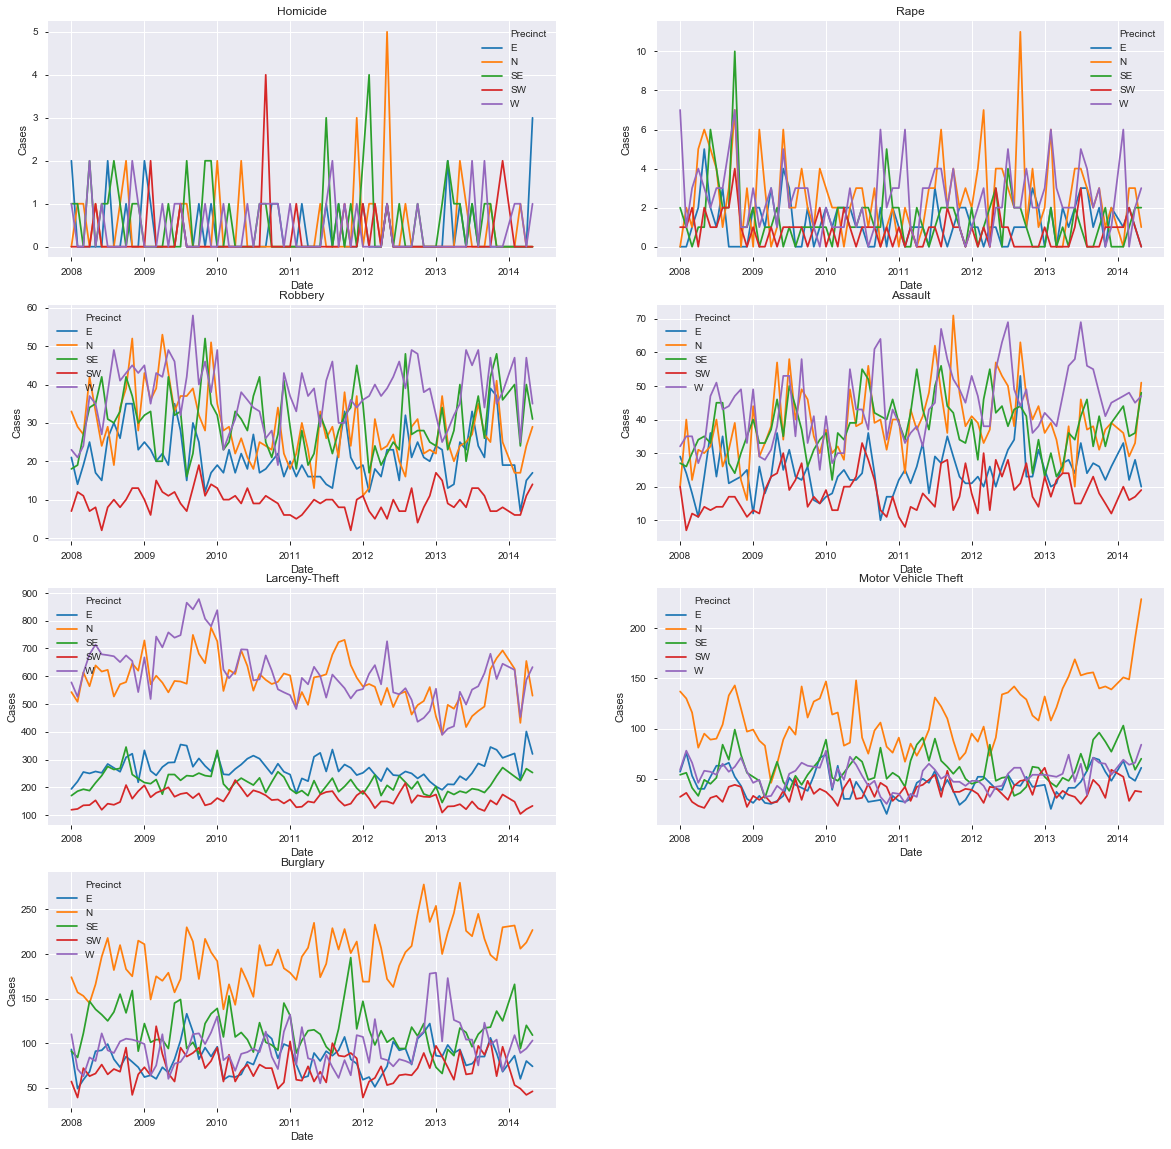

In [12]:
fig = plt.figure(figsize=(20, 20))
for i, crime_type in enumerate(crime_types):
  crime_type_data = df[df.Type == crime_type]
  crime_type_data = crime_type_data.groupby(['Precinct', 'Date'])['Cases'].sum().reset_index()

  fig.add_subplot(4, 2, i + 1)
  sns.lineplot(x="Date", y="Cases", hue="Precinct", data=crime_type_data)

  ax = plt.gca()
  ax.set_title(crime_type)

- General definitions (found on the Internet, not on the Police website):
    - Burglary: Entering a building to commit a crime
    - Robery: Threatening someone to give up something
    - Theft: Taking someone else's property without the owner's consent

# Combining all years, are there crime types that are more common within each precinct?

In [13]:
precincts = list(df['Precinct'].unique())
precincts

['N', 'W', 'E', 'SE', 'SW']

In [14]:
by_precinct = df.groupby(['Precinct', 'Type'])['Cases'].sum().reset_index()
by_precinct

,Precinct,Type,Cases
0,E,Assault,1864
1,E,Burglary,6301
2,E,Homicide,25
3,E,Larceny-Theft,20395
4,E,Motor Vehicle Theft,3358
5,E,Rape,95
6,E,Robbery,1616
7,N,Assault,2947
8,N,Burglary,15052
9,N,Homicide,29


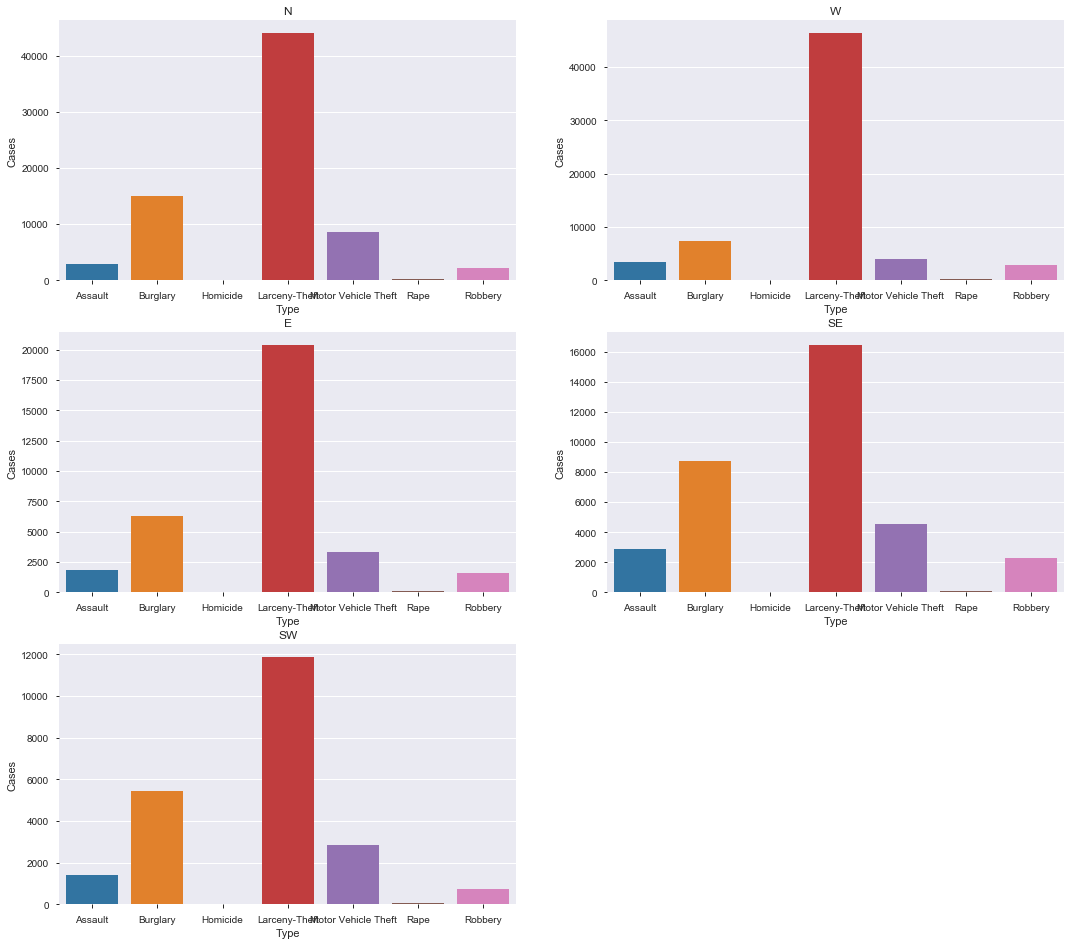

In [15]:
fig = plt.figure(figsize=(18, 22))
for i, precinct in enumerate(precincts):
  precinct_data = df[df.Precinct == precinct]
  precinct_data = precinct_data.groupby(['Precinct', 'Type'])['Cases'].sum().reset_index()

  fig.add_subplot(4, 2, i + 1)
  sns.barplot(data= precinct_data, x= 'Type', y= 'Cases')

  ax = plt.gca()
  ax.set_title(precinct)

Looks like Larceny-Theft is the most common crime in all precincts, followed by burglary and vehicle theft.

# Combining all years, were there more incidents in some precints than others (by crime type)? 

In [16]:
by_crime = df.groupby(['Type', 'Precinct'])['Cases'].sum().reset_index()
by_crime

,Type,Precinct,Cases
0,Assault,E,1864
1,Assault,N,2947
2,Assault,SE,2873
3,Assault,SW,1386
4,Assault,W,3354
5,Burglary,E,6301
6,Burglary,N,15052
7,Burglary,SE,8706
8,Burglary,SW,5446
9,Burglary,W,7290


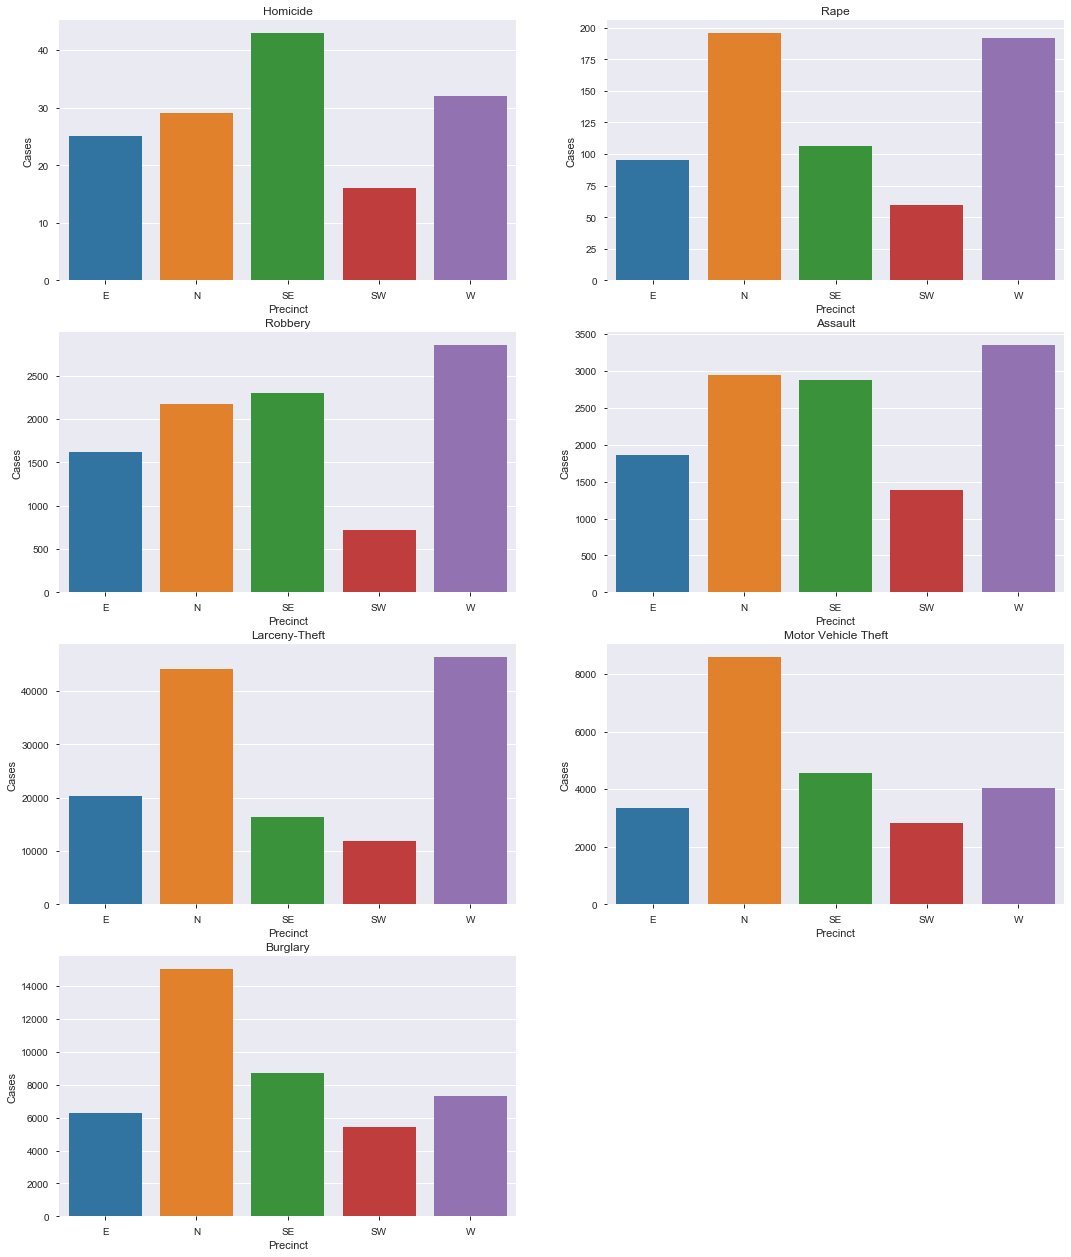

In [17]:
fig = plt.figure(figsize=(18, 22))
for i, crime_type in enumerate(crime_types):
  crime_type_data = df[df.Type == crime_type]
  crime_type_data = crime_type_data.groupby(['Precinct', 'Type'])['Cases'].sum().reset_index()

  fig.add_subplot(4, 2, i + 1)
  sns.barplot(data=crime_type_data, x='Precinct', y='Cases')

  ax = plt.gca()
  ax.set_title(crime_type)

North and West precincts seem to have had more incidents than other precincts. Southwest precinct seems to have had the least number of incidents across crime types.

# Let's break down the regions a little more...by sector 

Refer to the map again at:
https://www.seattle.gov/police/information-and-data/tweets-by-beat
E.g., Sector B refers to Beats B1, B2, and B3 on the map. Every sector has 3 beats.

In [18]:
by_crime_sector = df.groupby(['Type', 'Sector'])['Cases'].sum().reset_index()
by_crime_sector

,Type,Sector,Cases
0,Assault,B,511
1,Assault,C,376
2,Assault,D,719
3,Assault,E,820
4,Assault,F,877
5,Assault,G,668
6,Assault,J,594
7,Assault,K,1163
8,Assault,L,543
9,Assault,M,1079


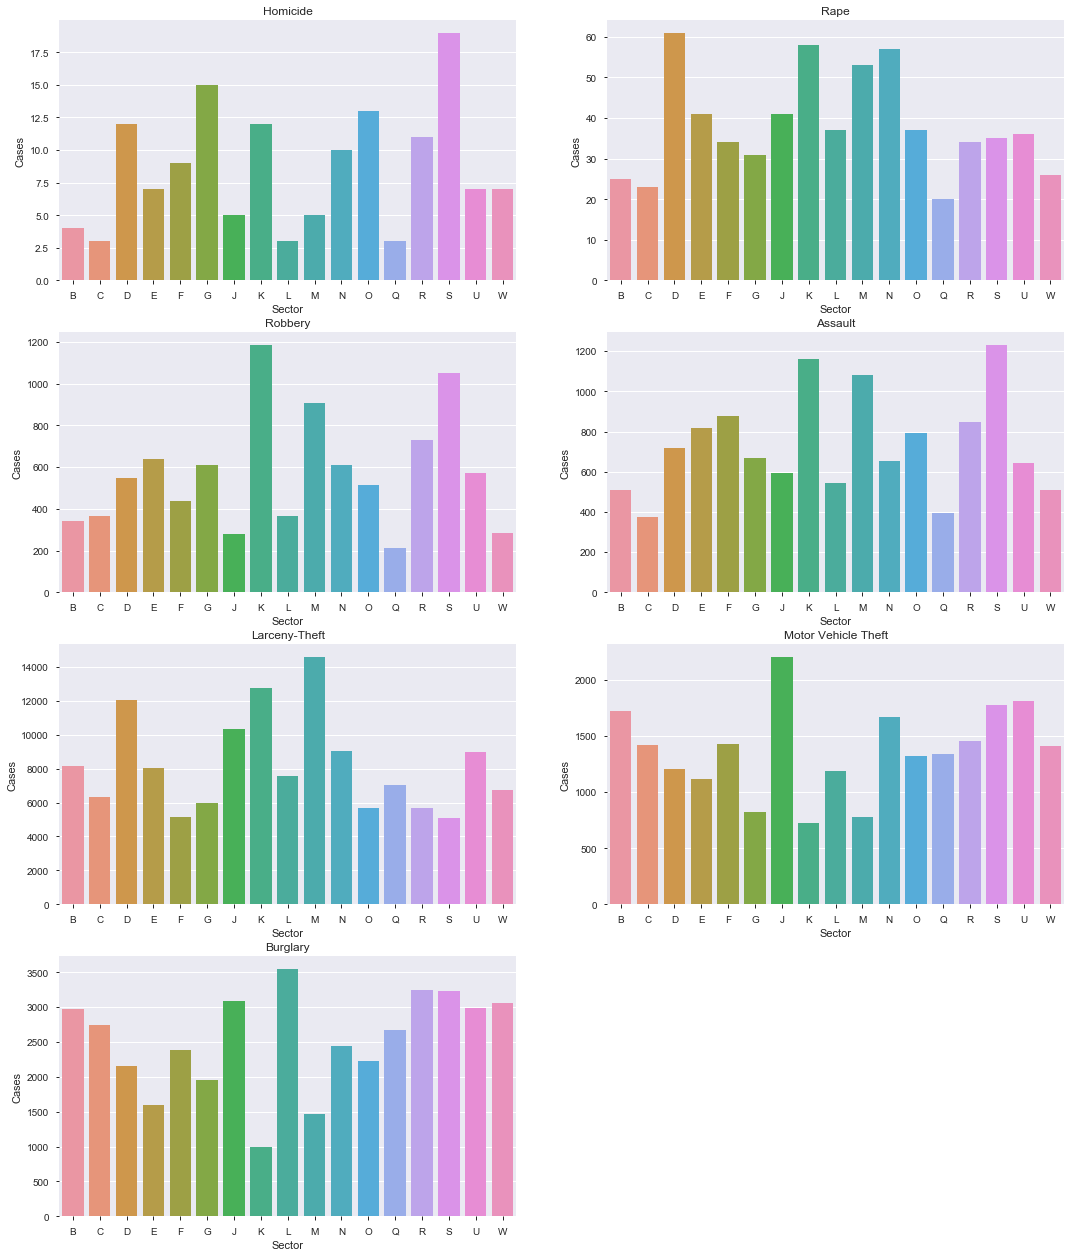

In [19]:
fig = plt.figure(figsize=(18, 22))
for i, crime_type in enumerate(crime_types):
  crime_type_data = df[df.Type == crime_type]
  crime_type_data = crime_type_data.groupby(['Sector', 'Type'])['Cases'].sum().reset_index()

  fig.add_subplot(4, 2, i + 1)
  sns.barplot(data=crime_type_data, x='Sector', y='Cases')

  ax = plt.gca()
  ax.set_title(crime_type)

Sector K (downtown) has more incidents of rape, robbery, assault, and larceny-theft.

# Let's try some word cloud across all regions of Seattle across all years

In [20]:
type_frequencies = df.groupby('Type')['Cases'].sum()
type_frequencies

Type
Assault                 12424
Burglary                42795
Homicide                  145
Larceny-Theft          139264
Motor Vehicle Theft     23392
Rape                      649
Robbery                  9658
Name: Cases, dtype: int64

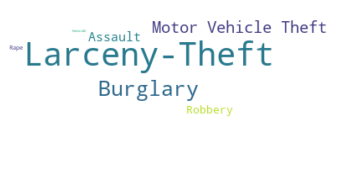

In [21]:
type_wc = wc.WordCloud(background_color="white")
type_wc.generate_from_frequencies(type_frequencies)

plt.axis("off")
plt.imshow(type_wc, interpolation="bilinear")
plt.show()

Larceny-theft is most common, followed by burglary and vehicle theft.